# Classification Models for Student Outcome Prediction

## Objective
Build and compare supervised classification models to predict student final outcomes: **Pass**, **Fail**, **Distinction**, **Withdrawn** based on demographics and VLE engagement.

## CRISP-DM Stage
Modelling and Evaluation

## Models Implemented
- Logistic Regression (baseline, multiclass)
- Random Forest Classifier (multiclass)
- XGBoost Classifier (multiclass)
- Evaluation with Precision, Recall, F1-Score, Confusion Matrix

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
import xgboost as xgb
import warnings
import re

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('All libraries imported successfully')
print('=' * 80)

All libraries imported successfully


## Section 1: Load Prepared Data

Load features and extract multiclass classification target (Distinction, Pass, Fail, Withdrawn) from final_result.

In [16]:
print('Loading prepared data...')
features = pd.read_pickle('../2_Outputs/features_prepared.pkl')
target = pd.read_pickle('../2_Outputs/target_prepared.pkl')
df_encoded = pd.read_pickle('../2_Outputs/df_encoded_full.pkl')

print(f'Features shape: {features.shape}')
print(f'Target shape: {target.shape}')

# Handle missing values
if features.isnull().sum().sum() > 0:
    print('\nImputing missing values...')
    features = features.fillna(0)

# Clean feature names for XGBoost
problematic_cols = [col for col in features.columns if any(c in str(col) for c in ['[', ']', '<'])]
if problematic_cols:
    print(f'Cleaning {len(problematic_cols)} feature names...')
    features.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', str(col)) for col in features.columns]

print('\n' + '=' * 80)
print('CREATING MULTICLASS CLASSIFICATION TARGET')
print('=' * 80)

# Extract final_result as multiclass target (4 classes)
if 'final_result' in df_encoded.columns:
    target_class = df_encoded.loc[target.index, 'final_result']
else:
    raise ValueError('final_result column not found in df_encoded')

# Encode labels: Distinction=0, Fail=1, Pass=2, Withdrawn=3 (alphabetical)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
target_class_encoded = le.fit_transform(target_class)
class_names = le.classes_

print(f'\nTarget classes: {list(class_names)}')
print(f'\nClassification target shape: {target_class_encoded.shape}')
print(f'\nClass distribution:')
for cls_name in class_names:
    cls_idx = le.transform([cls_name])[0]
    count = (target_class_encoded == cls_idx).sum()
    pct = count / len(target_class_encoded) * 100
    print(f'  {cls_name}: {count} ({pct:.1f}%)')

Loading prepared data...
Features shape: (23436, 46)
Target shape: (23436,)

CREATING MULTICLASS CLASSIFICATION TARGET

Target classes: ['Distinction', 'Fail', 'Pass', 'Withdrawn']

Classification target shape: (23436,)

Class distribution:
  Distinction: 2628 (11.2%)
  Fail: 5181 (22.1%)
  Pass: 11240 (48.0%)
  Withdrawn: 4387 (18.7%)


## Section 2: Train-Test Split

Divide data with stratification to maintain class balance.

In [17]:
print('\n' + '=' * 80)
print('TRAIN-TEST SPLIT (STRATIFIED)')
print('=' * 80)

X_train, X_test, y_train, y_test = train_test_split(
    features, target_class_encoded,
    test_size=0.2,
    random_state=42,
    stratify=target_class_encoded
)

print(f'Training set size: {X_train.shape}')
print(f'Testing set size: {X_test.shape}')
print(f'\nClass distribution (training):')
for cls_name in class_names:
    cls_idx = le.transform([cls_name])[0]
    count = (y_train == cls_idx).sum()
    pct = count / len(y_train) * 100
    print(f'  {cls_name}: {count} ({pct:.1f}%)')

print(f'\nClass distribution (testing):')
for cls_name in class_names:
    cls_idx = le.transform([cls_name])[0]
    count = (y_test == cls_idx).sum()
    pct = count / len(y_test) * 100
    print(f'  {cls_name}: {count} ({pct:.1f}%)')


TRAIN-TEST SPLIT (STRATIFIED)
Training set size: (18748, 46)
Testing set size: (4688, 46)

Class distribution (training):
  Distinction: 2102 (11.2%)
  Fail: 4145 (22.1%)
  Pass: 8992 (48.0%)
  Withdrawn: 3509 (18.7%)

Class distribution (testing):
  Distinction: 526 (11.2%)
  Fail: 1036 (22.1%)
  Pass: 2248 (48.0%)
  Withdrawn: 878 (18.7%)


## Section 3: Logistic Regression (Baseline)

Establish baseline with logistic regression.

In [18]:
print('\n' + '=' * 80)
print('LOGISTIC REGRESSION (BASELINE)')
print('=' * 80)

log_reg = LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial')
log_reg.fit(X_train, y_train)

y_train_pred_log = log_reg.predict(X_train)
y_test_pred_log = log_reg.predict(X_test)

acc_log = accuracy_score(y_test, y_test_pred_log)
prec_log = precision_score(y_test, y_test_pred_log, average='weighted')
rec_log = recall_score(y_test, y_test_pred_log, average='weighted')
f1_log = f1_score(y_test, y_test_pred_log, average='weighted')
cv_scores_log = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='f1_weighted')

print('\nLogistic Regression Results:')
print(f'  Accuracy:  {acc_log:.4f}')
print(f'  Precision (weighted): {prec_log:.4f}')
print(f'  Recall (weighted):    {rec_log:.4f}')
print(f'  F1-Score (weighted):  {f1_log:.4f}')
print(f'  5-Fold CV Mean F1: {cv_scores_log.mean():.4f} (+/- {cv_scores_log.std():.4f})')

print('\nConfusion Matrix:')
cm_log = confusion_matrix(y_test, y_test_pred_log)
print(cm_log)
print('\nClassification Report:')
print(classification_report(y_test, y_test_pred_log, target_names=class_names))


LOGISTIC REGRESSION (BASELINE)

Logistic Regression Results:
  Accuracy:  0.6670
  Precision (weighted): 0.6431
  Recall (weighted):    0.6670
  F1-Score (weighted):  0.6121
  5-Fold CV Mean F1: 0.6004 (+/- 0.0046)

Confusion Matrix:
[[  28    4  494    0]
 [   2  327  414  293]
 [  15   40 2193    0]
 [   0  267   32  579]]

Classification Report:
              precision    recall  f1-score   support

 Distinction       0.62      0.05      0.10       526
        Fail       0.51      0.32      0.39      1036
        Pass       0.70      0.98      0.82      2248
   Withdrawn       0.66      0.66      0.66       878

    accuracy                           0.67      4688
   macro avg       0.62      0.50      0.49      4688
weighted avg       0.64      0.67      0.61      4688



## Section 4: Random Forest Classifier

Implement ensemble classifier for non-linear patterns.

In [19]:
print('\n' + '=' * 80)
print('RANDOM FOREST CLASSIFIER')
print('=' * 80)

rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)

y_train_pred_rf = rf_clf.predict(X_train)
y_test_pred_rf = rf_clf.predict(X_test)

acc_rf = accuracy_score(y_test, y_test_pred_rf)
prec_rf = precision_score(y_test, y_test_pred_rf, average='weighted')
rec_rf = recall_score(y_test, y_test_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_test_pred_rf, average='weighted')
cv_scores_rf = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='f1_weighted')

print('\nRandom Forest Results:')
print(f'  Accuracy:  {acc_rf:.4f}')
print(f'  Precision (weighted): {prec_rf:.4f}')
print(f'  Recall (weighted):    {rec_rf:.4f}')
print(f'  F1-Score (weighted):  {f1_rf:.4f}')
print(f'  5-Fold CV Mean F1: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std():.4f})')

print('\nConfusion Matrix:')
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
print(cm_rf)


RANDOM FOREST CLASSIFIER

Random Forest Results:
  Accuracy:  0.6856
  Precision (weighted): 0.6715
  Recall (weighted):    0.6856
  F1-Score (weighted):  0.6286
  5-Fold CV Mean F1: 0.6185 (+/- 0.0058)

Confusion Matrix:
[[  30    0  496    0]
 [   1  320  378  337]
 [  13   47 2186    2]
 [   0  176   24  678]]


## Section 5: XGBoost Classifier

Apply gradient boosting for classification.

In [20]:
print('\n' + '=' * 80)
print('XGBOOST CLASSIFIER')
print('=' * 80)

xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    objective='multi:softmax',
    num_class=len(class_names)
)

xgb_clf.fit(X_train, y_train, verbose=False)

y_train_pred_xgb = xgb_clf.predict(X_train)
y_test_pred_xgb = xgb_clf.predict(X_test)

acc_xgb = accuracy_score(y_test, y_test_pred_xgb)
prec_xgb = precision_score(y_test, y_test_pred_xgb, average='weighted')
rec_xgb = recall_score(y_test, y_test_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test, y_test_pred_xgb, average='weighted')
cv_scores_xgb = cross_val_score(xgb_clf, X_train, y_train, cv=5, scoring='f1_weighted')

print('\nXGBoost Results:')
print(f'  Accuracy:  {acc_xgb:.4f}')
print(f'  Precision (weighted): {prec_xgb:.4f}')
print(f'  Recall (weighted):    {rec_xgb:.4f}')
print(f'  F1-Score (weighted):  {f1_xgb:.4f}')
print(f'  5-Fold CV Mean F1: {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std():.4f})')

print('\nConfusion Matrix:')
cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)
print(cm_xgb)


XGBOOST CLASSIFIER

XGBoost Results:
  Accuracy:  0.6890
  Precision (weighted): 0.6690
  Recall (weighted):    0.6890
  F1-Score (weighted):  0.6414
  5-Fold CV Mean F1: 0.6281 (+/- 0.0074)

Confusion Matrix:
[[  55    0  471    0]
 [   2  346  363  325]
 [  31   47 2163    7]
 [   1  191   20  666]]


## Section 6: Model Comparison and Visualisation

Compare classification models with confusion matrices and ROC curves.


CLASSIFICATION MODEL COMPARISON

              Model  Accuracy  Precision   Recall  F1-Score
            XGBoost  0.688993   0.669037 0.688993  0.641445
      Random Forest  0.685580   0.671487 0.685580  0.628585
Logistic Regression  0.667022   0.643087 0.667022  0.612125


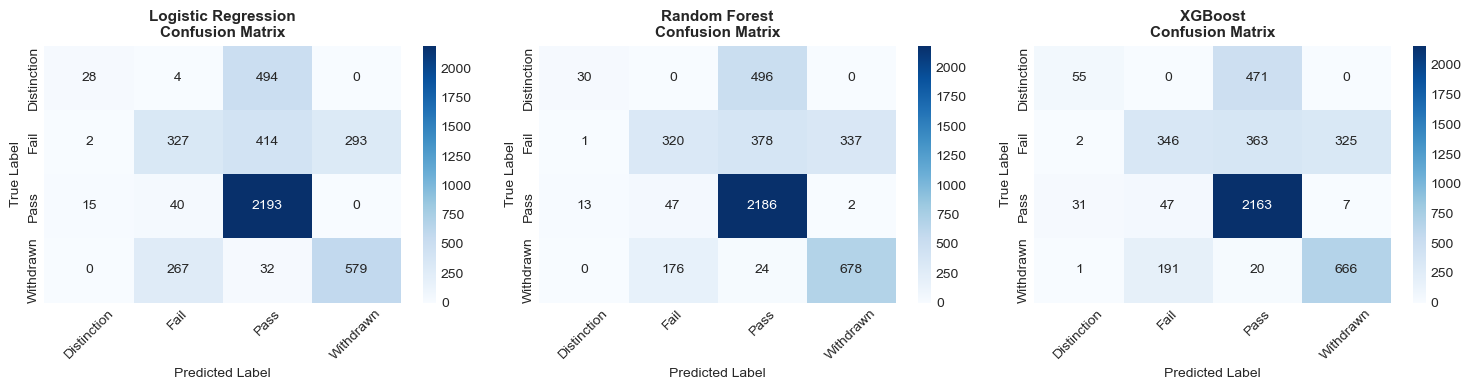

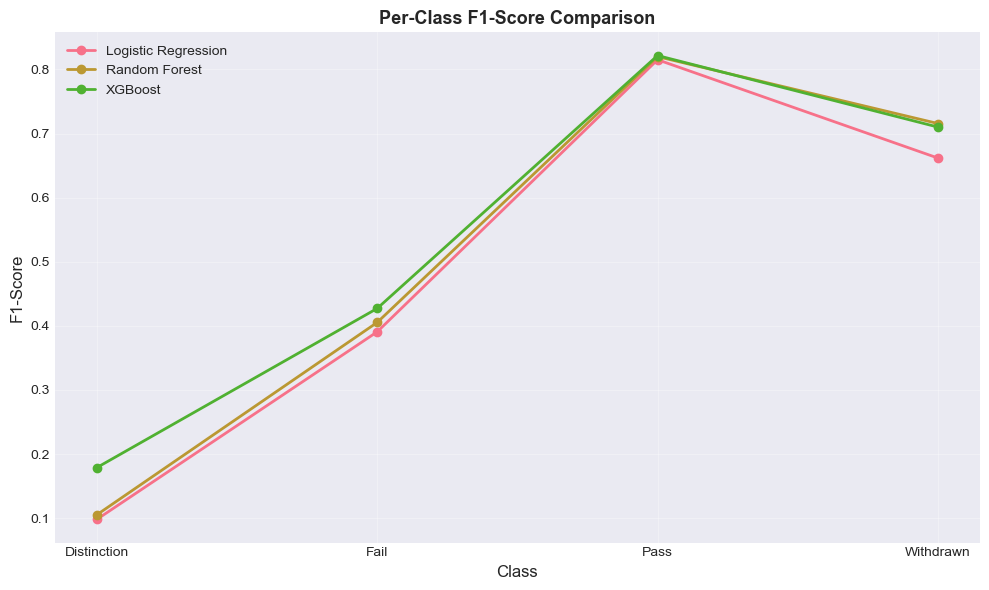


Best Model: XGBoost
F1-Score (weighted): 0.6414
Accuracy: 0.6890

Best model saved for final notebook


In [21]:
print('\n' + '=' * 80)
print('CLASSIFICATION MODEL COMPARISON')
print('=' * 80)

comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [acc_log, acc_rf, acc_xgb],
    'Precision': [prec_log, prec_rf, prec_xgb],
    'Recall': [rec_log, rec_rf, rec_xgb],
    'F1-Score': [f1_log, f1_rf, f1_xgb]
})

comparison_df = comparison_df.sort_values('F1-Score', ascending=False)
print('\n' + comparison_df.to_string(index=False))

# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (cm, title, ax) in enumerate(zip(
    [cm_log, cm_rf, cm_xgb],
    ['Logistic Regression', 'Random Forest', 'XGBoost'],
    axes
)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=class_names, yticklabels=class_names)
    ax.set_title(f'{title}\nConfusion Matrix', fontsize=11, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Per-class performance bar chart
fig, ax = plt.subplots(figsize=(10, 6))
for model_name, y_pred in zip(['Logistic Regression', 'Random Forest', 'XGBoost'], 
                               [y_test_pred_log, y_test_pred_rf, y_test_pred_xgb]):
    from sklearn.metrics import f1_score
    per_class_f1 = f1_score(y_test, y_pred, average=None)
    x_pos = np.arange(len(class_names))
    ax.plot(x_pos, per_class_f1, marker='o', label=model_name, linewidth=2)

ax.set_xticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=0)
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('Per-Class F1-Score Comparison', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f'\nBest Model: {comparison_df.iloc[0]["Model"]}')
print(f'F1-Score (weighted): {comparison_df.iloc[0]["F1-Score"]:.4f}')
print(f'Accuracy: {comparison_df.iloc[0]["Accuracy"]:.4f}')

# Save best model
best_model_name = comparison_df.iloc[0]['Model']
if 'Random Forest' in best_model_name:
    best_clf = rf_clf
elif 'XGBoost' in best_model_name:
    best_clf = xgb_clf
else:
    best_clf = log_reg

import pickle
pickle.dump(best_clf, open('../2_Outputs/best_classification_model.pkl', 'wb'))
print('\nBest model saved for final notebook')